### Prediction of scraped MyAnimeList Data ###

Our goal in this project is to predict the popularity ranking of a supposed new show coming out using the basic information we would know about it before airing. <br>
We scraped our data from the side MyAnimeList (MAL for short). Link: https://myanimelist.net <br>
Example page from which we extracted data: (Attack on Titan) https://myanimelist.net/anime/16498

Importing 'numpy', 'pandas' and 'seaborn' for data management and visualization. 

In [2697]:
import numpy as np
import pandas as pd
import seaborn as sns

Prevent redundant warnings from pandas.

In [2698]:
import warnings
warnings.filterwarnings('ignore')

Reading the scraped data. The columns given regarding a show:
 - Title.
 - MAL Id. This method's input, its returned for convenience.
 - Type. For example: 'Movie', 'TV', ect.
 - Episode's duration. For example: '23 min', '2 hour', ect.
 - Publishing animation studio.
 - Source type. For example: 'Manga', 'Visual' (short for Visual Novel), ect.
 - Genres. For example: 'Fantasy', 'Romance', 'Action', etc.
 - Themes. For example: 'Military', 'Apocalypse', etc.
 - Rating. For example: 'PG-13'.
 - Popularity. Popularity ranking, lower is better.
 - Score. x out of 10, given by MAL user.
 - Year. Release year. For example: '2022'.
 - Number of Episodes. For example: '24'.
 - Demographic. Intended demographic. For example: 'shonen' (meaning young boys).

<b> Important Notes: </b> (TL;DR)
* Anime with lower Popularity means it was ranked lower, hence it means that the anime was viewed by more people.
* During our analysis and model training we won't be using the given Score of an anime to avoid data leakage as a popular anime is more likely to have a better score.

In [2699]:
df = pd.read_csv("anime_df_raw.csv", sep=';')
df.head(10)

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,Popularity,Score,Demographic,Year
0,0,Fullmetal Alchemist: Brotherhood,5114,TV,64,24 min. per ep.,Bones,Manga,"Action,Adventure,Comedy,Drama,Fantasy",N\A,R - 17+ (violence & profanity),3,9.15,Shounen,2009
1,1,Shingeki no Kyojin: The Final Season Part 2,48583,TV,12,23 min. per ep.,MAPPA,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",R - 17+ (violence & profanity),220,9.15,Shounen,2022
2,2,Steins;Gate,9253,TV,24,24 min. per ep.,White Fox,Visual,"Drama,Sci-Fi,Suspense",N\A,PG-13 - Teens 13 or older,13,9.09,N\A,2011
3,3,Gintama°,28977,TV,51,24 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,335,9.09,Shounen,2015
4,4,Shingeki no Kyojin Season 3 Part 2,38524,TV,10,23 min. per ep.,Wit Studio,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",R - 17+ (violence & profanity),32,9.08,Shounen,2019
5,5,Fruits Basket: The Final,42938,TV,13,23 min. per ep.,TMS Entertainment,Manga,"Drama,Romance,Slice of Life,Supernatural",N\A,PG-13 - Teens 13 or older,626,9.06,Shoujo,2021
6,6,Gintama',9969,TV,51,24 min. per ep.,Sunrise,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,380,9.06,Shounen,2011
7,7,Gintama: The Final,39486,Movie,1,1 hr. 44 min.,Bandai Namco Pictures,Manga,"Action,Comedy,Drama,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,1798,9.05,Shounen,2021
8,8,Hunter x Hunter (2011),11061,TV,148,23 min. per ep.,Madhouse,Manga,"Action,Adventure,Fantasy",N\A,PG-13 - Teens 13 or older,10,9.05,Shounen,2011
9,9,Gintama': Enchousen,15417,TV,13,24 min. per ep.,Sunrise,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,683,9.04,Shounen,2012


Delete null information. (if exists)

In [2700]:
data_null_total = pd.DataFrame(df.isna().sum()).T.rename({0:'total null'})
data_null_total

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,Popularity,Score,Demographic,Year
total null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,204


Check for duplicated data entries.

In [2701]:
df = df.drop_duplicates(keep='first')

Lets remove entries with 'None' data:
 - 'add some' is a placeholder of shows without a known studio.
 - 'Unknown' source type.
 - All shows without listed genres.
 - All shows without a release year.

In [2702]:
no_studio = df[df['Studios'].str.contains('add some')]
df = pd.concat([df, no_studio])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_studio.index)) )

Removed 1163 entries.


In [2703]:
no_source = df[df['Source Type'].str.contains('Unknown')]
df = pd.concat([df, no_source])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_source.index)) )

Removed 853 entries.


In [2704]:
no_genre = df[df['Genres'] == 'N\A']
df = pd.concat([df, no_genre])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_genre.index)) )

Removed 1548 entries.


In [2705]:
no_ep_num = df[df['Number of Episodes'] == 'Unknown']
df = pd.concat([df, no_ep_num])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_ep_num.index)) )

Removed 24 entries.


In [2706]:
clean_df = df[pd.to_numeric(df['Year'], errors='coerce').notnull()]

print( 'Removed {} entries.'.format(len(df.index) - len(clean_df.index)) )
df = clean_df

Removed 41 entries.


In [2707]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5868 entries, 0 to 9492
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          5868 non-null   int64  
 1   Title               5868 non-null   object 
 2   MAL Id              5868 non-null   int64  
 3   Type                5868 non-null   object 
 4   Number of Episodes  5868 non-null   object 
 5   Episode Duration    5868 non-null   object 
 6   Studios             5868 non-null   object 
 7   Source Type         5868 non-null   object 
 8   Genres              5868 non-null   object 
 9   Themes              5868 non-null   object 
 10  Rating              5868 non-null   object 
 11  Popularity          5868 non-null   int64  
 12  Score               5868 non-null   float64
 13  Demographic         5868 non-null   object 
 14  Year                5868 non-null   object 
dtypes: float64(1), int64(3), object(11)
memory usage: 733.5

Lets parse the data that is still saved as a string so we can work with it.

Lets convert the Release year to 'int'.

In [2708]:
df['Year'] = df['Year'].astype(int)

lets convert 'Number of Episodes' to an 'int.

In [2709]:
df['Number of Episodes'] = df['Number of Episodes'].astype(int)

Parsing Episode Duration to 'int' minutes.

In [2710]:
def DurationToMin(duration_str):
    duration_list = duration_str.split(' ')
    duration = 0

    i = 0
    for word in duration_list:
        if word == 'min.':
            duration += int(duration_list[i-1])
        elif word == 'hr.':
            duration += 60*int(duration_list[i-1])
        i += 1

    return duration

In [2711]:
df['Duration'] = df['Episode Duration'].apply(lambda x: DurationToMin(x))

Lets remove shows with episode duration smaller than 1 minute.

In [2712]:
no_duration = df[df['Duration'] == 0]
df = pd.concat([df, no_duration])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_duration.index)) )

Removed 16 entries.


The models cannot accept string values hence we will create boolean values for each genre related to a show. We will convert the True/False value into 1/0 (respectively) for it to be numerical data.

In [2713]:
def GetAttributeList(column, dataframe, none_value):
    attribute_list = []
    for cell in dataframe[column]:
        attributes = cell.split(',')
        for attribute in attributes:
            if attribute not in attribute_list and none_value not in attribute:
                attribute_list.append(attribute)

    return attribute_list

def AttributeListToBoolFlags(column, dataframe, none_value):
    attribute_list = GetAttributeList(column, dataframe, none_value)

    print( 'There are {} {}.\n {}'.format(len(attribute_list), column, attribute_list) )

    for genre in attribute_list:
        dataframe[genre] = dataframe.apply (lambda row: 1 if genre in row['Genres'] else 0, axis=1)

In [2714]:
AttributeListToBoolFlags('Genres', df, 'N\A')

There are 20 Genres.
 ['Action', 'Adventure', 'Comedy', 'Drama', 'Fantasy', 'Mystery', 'Sci-Fi', 'Suspense', 'Romance', 'Slice of Life', 'Supernatural', 'Sports', 'Award Winning', 'Ecchi', 'Horror', 'Avant Garde', 'Boys Love', 'Gourmet', 'Girls Love', 'Work Life']


lets remove the genres that we barely see (< 5 times), if left alone they would serve as edge cases for our predictions.

In [2715]:
genre_list = GetAttributeList('Genres', df, 'N\A')

for genre in genre_list:
    count = df[genre].value_counts()[1]
    if count < 5:
        df = df.drop(genre, axis=1)

The models cannot accept string values hence we will create boolean values for the rating, type and demographic related to each show just as we did for genre.

In [2716]:
AttributeListToBoolFlags('Rating', df, 'None')
AttributeListToBoolFlags('Type', df, 'N\A')
AttributeListToBoolFlags('Demographic', df, 'N\A')

There are 5 Rating.
 [' R - 17+ (violence & profanity)  ', ' PG-13 - Teens 13 or older  ', ' R+ - Mild Nudity  ', ' PG - Children  ', ' G - All Ages  ']
There are 5 Type.
 ['TV', 'Movie', 'OVA', 'ONA', 'Special']
There are 5 Demographic.
 ['Shounen', 'Shoujo', 'Seinen', 'Josei', 'Kids']


In [2717]:
df.to_csv("anime_df_clean.csv", sep=';', index=False)
df

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,...,TV,Movie,OVA,ONA,Special,Shounen,Shoujo,Seinen,Josei,Kids
0,0,Fullmetal Alchemist: Brotherhood,5114,TV,64,24 min. per ep.,Bones,Manga,"Action,Adventure,Comedy,Drama,Fantasy",N\A,...,0,0,0,0,0,0,0,0,0,0
1,1,Shingeki no Kyojin: The Final Season Part 2,48583,TV,12,23 min. per ep.,MAPPA,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",...,0,0,0,0,0,0,0,0,0,0
2,2,Steins;Gate,9253,TV,24,24 min. per ep.,White Fox,Visual,"Drama,Sci-Fi,Suspense",N\A,...,0,0,0,0,0,0,0,0,0,0
3,3,Gintama°,28977,TV,51,24 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",...,0,0,0,0,0,0,0,0,0,0
4,4,Shingeki no Kyojin Season 3 Part 2,38524,TV,10,23 min. per ep.,Wit Studio,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9480,9480,Sora to Umi no Aida,36000,TV,12,23 min. per ep.,TMS Entertainment,Game,"Adventure,Fantasy,Sci-Fi",N\A,...,0,0,0,0,0,0,0,0,0,0
9483,9483,Tuzki: Love Assassin,23903,ONA,1,2 min.,Studio 4°C,Other,"Comedy,Romance",N\A,...,0,0,0,0,0,0,0,0,0,0
9487,9487,California Crisis: Tsuigeki no Juuka,3127,OVA,1,45 min.,"Studio Unicorn,Hiro Media",Original,"Action,Adventure,Sci-Fi",N\A,...,0,0,0,0,0,0,0,0,0,0
9491,9491,Hipira-kun ONA,22983,ONA,2,5 min. per ep.,Sunrise,Picture,"Comedy,Fantasy,Supernatural",N\A,...,0,0,0,0,0,0,0,0,0,0


Now that we cleaned the data we will try to gain some insight into the correlation between parameters and confirm our own suspicions.

### Correlation ###

In [2726]:
def CorrelationTable(data, title):
    # Compute the correlation matrix:
    pandas_correlation = data.corr()

    # Generating a mask for the upper triangle for a cleaner table:
    mask = np.triu(np.ones_like(pandas_correlation, dtype=bool))

    # Set up the matplotlib figure:
    f, ax = plt.subplots(figsize=(30, 30))

    # Generate a custom diverging colormap:
    cmap = sns.diverging_palette(20, 230, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio:
    sns.heatmap(pandas_correlation, mask=mask, cmap=cmap, vmax=.8, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

    # Title:
    plt.title(title)

    plt.show()

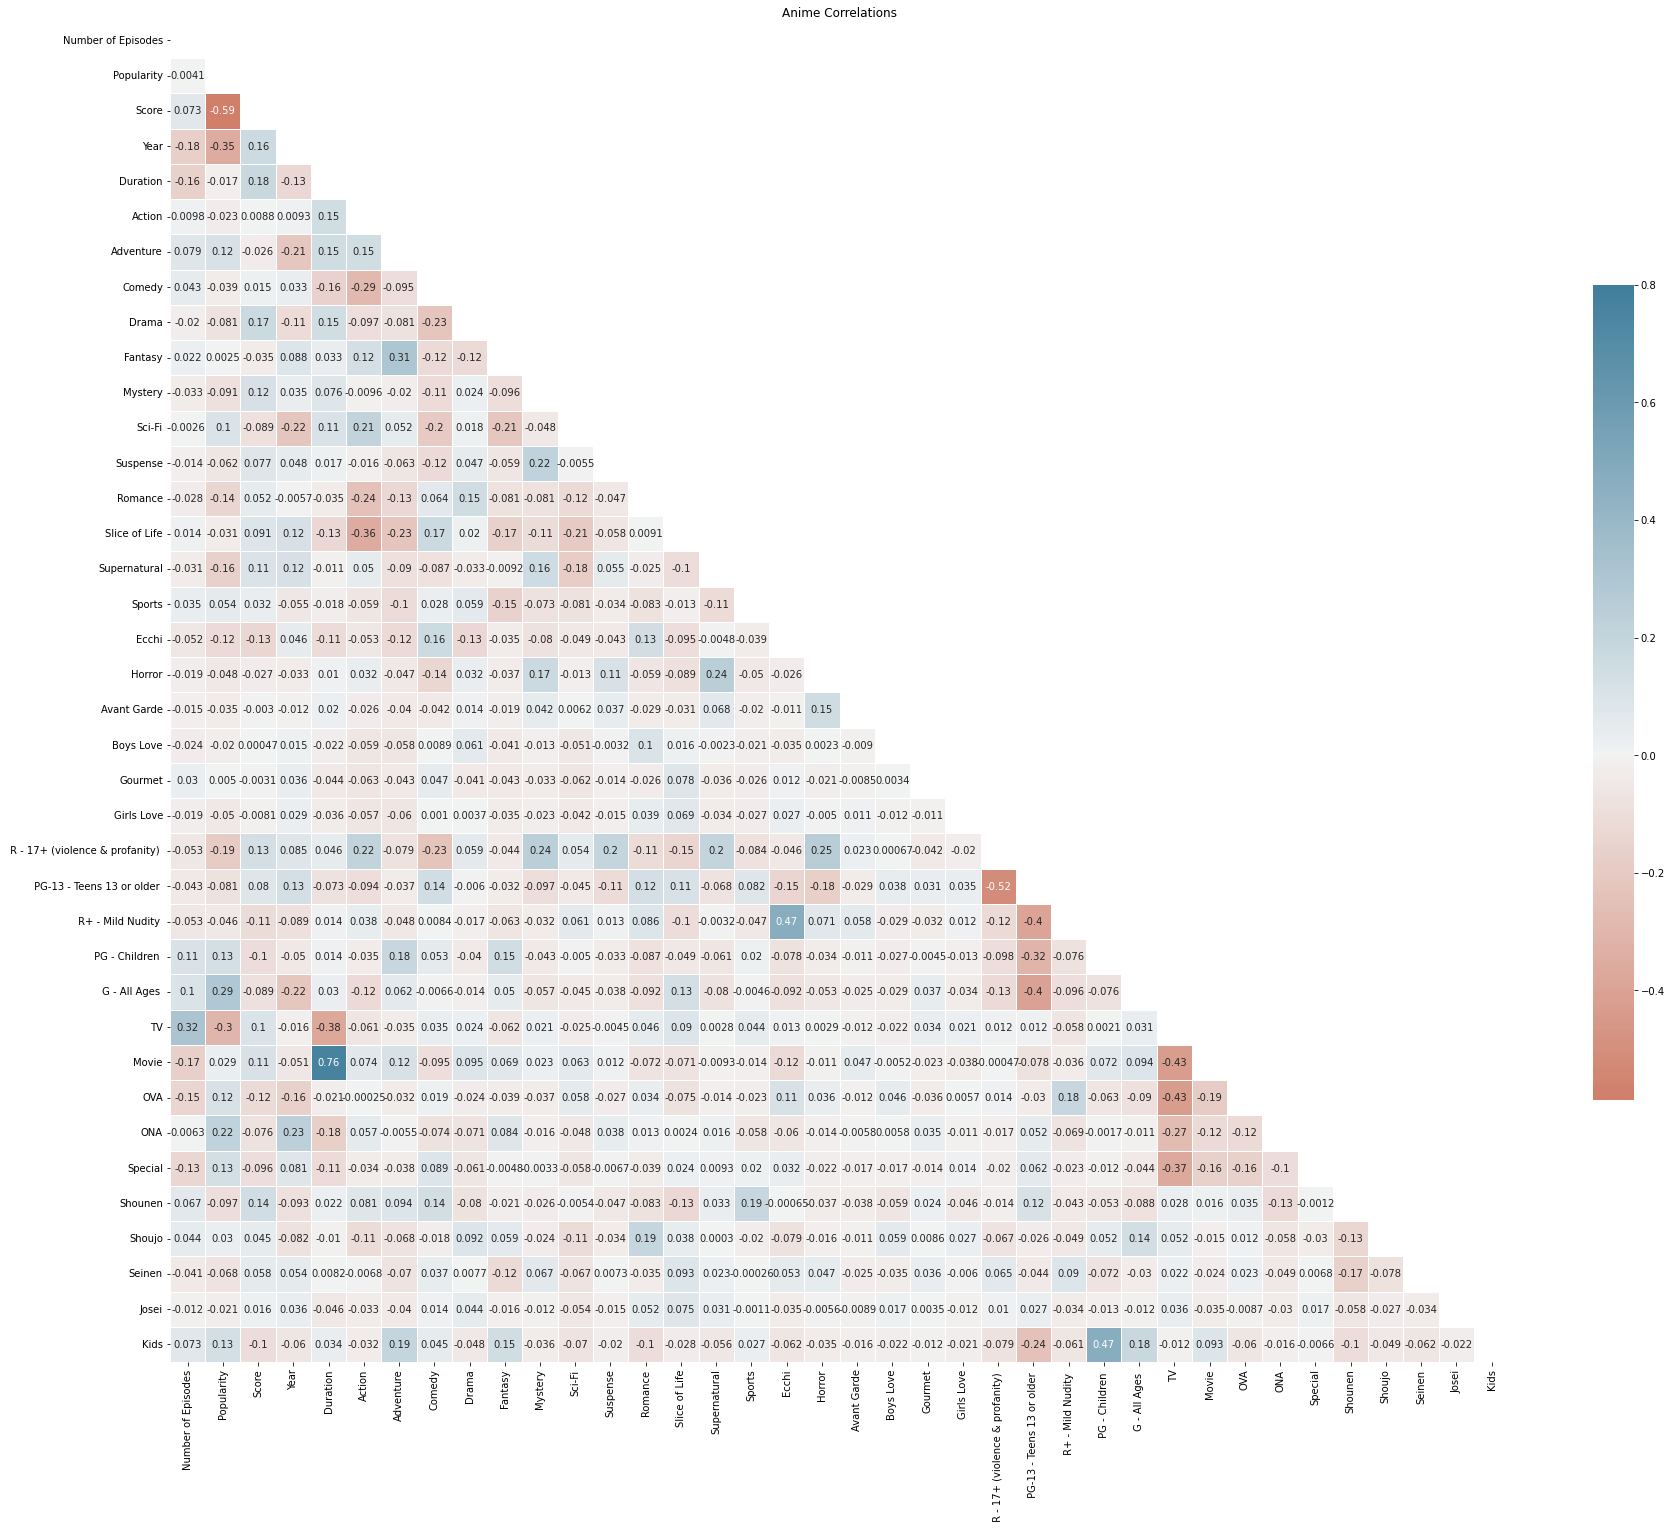

In [2628]:
corr_df = df.drop(['Title', 'Episode Duration', 'Genres', 'Themes', 'Studios', 'Source Type', 'Type', 'Rating', 'Demographic', 'MAL Id', 'Unnamed: 0'], axis=1)
CorrelationTable(corr_df, 'Anime Correlations')

<b> Reminder! </b> <br>
Anime with lower Popularity means it was ranked lower, hence it means that the anime was viewed by more people.
In addition, we looked at Score even though we will not use it because of its strong connection to Popularity in order to gain further insight.

<b> Important connections: </b> (Relatively strong relations to popularity)
* Year, Popularity : (-0.35) There is a strong connection between year and popularity, that shows new anime tend to be more popular (ranked lower).
* Romance, Popularity: (-0.14) Anime with romance genre tend to get a lower rank.
* Supernatural, Popularity: (-0.16) Anime with Supernatural genre tend to get a lower rank.
* Ecchi, Popularity: (-0.12) Anime with Ecchi genre tend to get a lower rank.
* R - 17+ (violence & profanity), Popularity: (-0.19) Anime with this rating tends to be lower ranked.
* G - All Ages, Popularity: (0.29) There is a strong connection that indicates anime for all ages will be higher ranked.
* TV, Popularity: (-0.3) There is a strong connection between anime's rank and the fact it was aired on TV.
* ONA, Popularity: (0.22) There is a relatively strong connection between anime's rank and the fact it was aired on a website.
* Shounen, Popularity: (-0.097) Anime with Shounen demography tend to get lower ranked.
* Kids, Popularity: (0.13) Anime for kids tend to be higher ranked.

<b> Relatively strong connections to score: </b>
* Duration , Score: (0.18) Anime with higher duration per episode tend to get a better score.
* Drama, Score: (0.17) Anime with Drama genre tend to get higher score.
* Supernatural, Score: (0.11): Anime with supernatural genre tend to get higher score.
* R - 17+ (violence & profanity), Score: (0.13) Anime with this rating tends to get higher score.
* TV, Score: (0.1) Anime that was aired on TV tend to get higher score.
* Shounen, Score : (0.14) Anime with Shounen demography tend to get higher score.
* Kids, Score: (-0.1) Anime for kids tend to get lower score.
* Score, Number of Episodes: (0.073) Anime with more episodes tend to get a greater score.
* Year, Score: (0.16) New anime tend to receive a greater score.

<b> Examples for expectations using the connections: </b> <br>

We expect that an anime with the following data will be relatively lower ranked (With lower Popularity):
* The anime was released in the last few years
* The anime's genres are: Romance, Supernatural , Ecchi 
* The anime is rated 17+ (violence & profanity)
* The anime was aired on TV
* The anime's demography is Shounen

We expect that an anime with the following data will be relatively higher ranked (With higher popularity):
* The anime was released a relatively long time ago
* The anime's genres are: Adventure, Sci-Fi
* The anime is rated for all ages
* The anime was aired on a website 
* The anime demography is kids

### Graphs ###

<AxesSubplot:title={'center':'Studio and the Number of Published Anime'}>

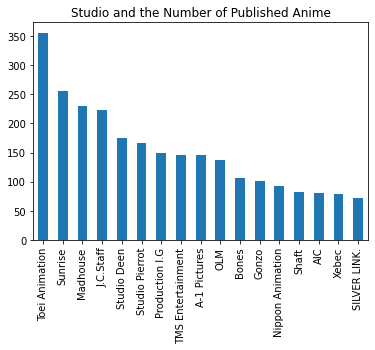

In [2718]:
#MAKE MEDIAN STUDIO POPULARITY
#MAKE CHART

import matplotlib.pyplot as plt 

plt.title('Studio and the Number of Published Anime')
studio_appearances = df.Studios.value_counts()
studio_appearances[studio_appearances > 70].plot(kind = 'bar')

<AxesSubplot:title={'center':'Genres and the Number of Published Anime'}>

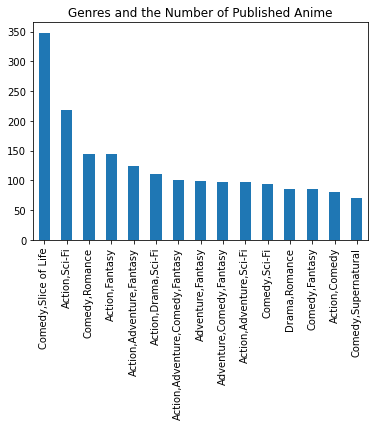

In [2722]:

#cut genres
#median genre popularity
#make chart of genre vs populrity


plt.title('Genres and the Number of Published Anime')
genre_appearances = df.Genres.value_counts()
genre_appearances[genre_appearances > 70].plot(kind = 'bar')

<AxesSubplot:title={'center':'How many times each popularity appears modul 5000'}, xlabel='Popularity'>

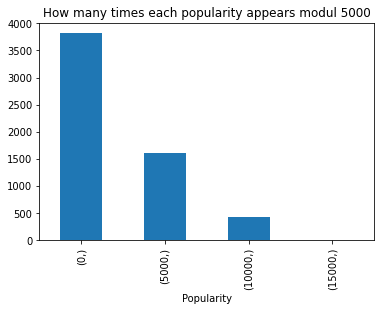

In [2620]:
plt.title('How many times each popularity appears modul 5000')
df_popularity = df[['Popularity']].apply(lambda x: (x-(x%5000)))
df_popularity

df_popularity_count = df_popularity.value_counts()
df_popularity_count.plot(kind = 'bar')

<AxesSubplot:title={'center':'Source and the Number of Published Anime'}>

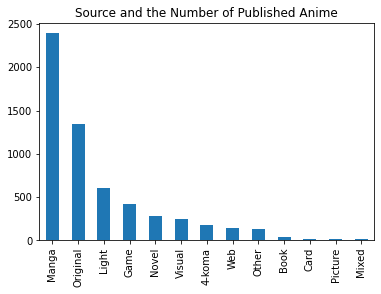

In [2621]:
plt.title('Source and the Number of Published Anime')
source_appearances = df['Source Type'].value_counts()
source_appearances[source_appearances>10].plot(kind = 'bar')

In [2723]:
df_highpop = df[df['Popularity']<100]
df_highpop

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,...,TV,Movie,OVA,ONA,Special,Shounen,Shoujo,Seinen,Josei,Kids
0,0,Fullmetal Alchemist: Brotherhood,5114,TV,64,24 min. per ep.,Bones,Manga,"Action,Adventure,Comedy,Drama,Fantasy",N\A,...,0,0,0,0,0,0,0,0,0,0
2,2,Steins;Gate,9253,TV,24,24 min. per ep.,White Fox,Visual,"Drama,Sci-Fi,Suspense",N\A,...,0,0,0,0,0,0,0,0,0,0
4,4,Shingeki no Kyojin Season 3 Part 2,38524,TV,10,23 min. per ep.,Wit Studio,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",...,0,0,0,0,0,0,0,0,0,0
8,8,Hunter x Hunter (2011),11061,TV,148,23 min. per ep.,Madhouse,Manga,"Action,Adventure,Fantasy",N\A,...,0,0,0,0,0,0,0,0,0,0
18,18,Code Geass: Hangyaku no Lelouch R2,2904,TV,25,24 min. per ep.,Sunrise,Original,"Action,Drama,Sci-Fi","Mecha,Military,Super Power",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840,2840,Sword Art Online,11757,TV,25,23 min. per ep.,A-1 Pictures,Light,"Action,Adventure,Fantasy,Romance",N\A,...,0,0,0,0,0,0,0,0,0,0
2964,2964,Deadman Wonderland,6880,TV,12,24 min. per ep.,Manglobe,Manga,"Action,Horror,Sci-Fi,Supernatural",N\A,...,0,0,0,0,0,0,0,0,0,0
3342,3342,Highschool of the Dead,8074,TV,12,24 min. per ep.,Madhouse,Manga,"Action,Horror,Supernatural,Ecchi",N\A,...,0,0,0,0,0,0,0,0,0,0
3633,3633,Tokyo Ghoul √A,27899,TV,12,24 min. per ep.,Studio Pierrot,Manga,"Action,Drama,Horror,Mystery,Supernatural",N\A,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:title={'center':'Source and the Number of Published Anime for High Popularity Anime'}>

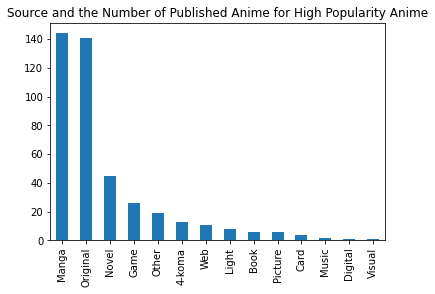

In [2623]:
plt.title('Source and the Number of Published Anime for High Popularity Anime')
source_appearances = df_highpop['Source Type'].value_counts()
source_appearances[source_appearances>0].plot(kind = 'bar')

In [2624]:
df_lowpop = df[df['Popularity']<2500]
df_lowpop

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,...,TV,Movie,OVA,ONA,Special,Shounen,Shoujo,Seinen,Josei,Kids
0,0,Fullmetal Alchemist: Brotherhood,5114,TV,64,24 min. per ep.,Bones,Manga,"Action,Adventure,Comedy,Drama,Fantasy",N\A,...,1,0,0,0,0,1,0,0,0,0
1,1,Shingeki no Kyojin: The Final Season Part 2,48583,TV,12,23 min. per ep.,MAPPA,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",...,1,0,0,0,0,1,0,0,0,0
2,2,Steins;Gate,9253,TV,24,24 min. per ep.,White Fox,Visual,"Drama,Sci-Fi,Suspense",N\A,...,1,0,0,0,0,0,0,0,0,0
3,3,Gintama°,28977,TV,51,24 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",...,1,0,0,0,0,1,0,0,0,0
4,4,Shingeki no Kyojin Season 3 Part 2,38524,TV,10,23 min. per ep.,Wit Studio,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9144,9144,Taboo Tattoo,29758,TV,12,24 min. per ep.,J.C.Staff,Manga,"Action,Mystery,Supernatural","Martial Arts,Super Power",...,1,0,0,0,0,0,0,1,0,0
9177,9177,Dokyuu Hentai HxEros,40623,TV,12,23 min. per ep.,Project No.9,Manga,"Action,Comedy,Supernatural,Ecchi",N\A,...,1,0,0,0,0,1,0,0,0,0
9272,9272,Sin: Nanatsu no Taizai,33834,TV,12,23 min. per ep.,"Artland,TNK",Other,"Fantasy,Ecchi",N\A,...,1,0,0,0,0,0,0,0,0,0
9462,9462,Kenja no Deshi wo Nanoru Kenja,42072,TV,12,23 min. per ep.,Studio A-CAT,Light,"Adventure,Fantasy",N\A,...,1,0,0,0,0,0,0,0,0,0


<AxesSubplot:title={'center':'Source and the Number of Published Anime for Low Popularity Anime'}>

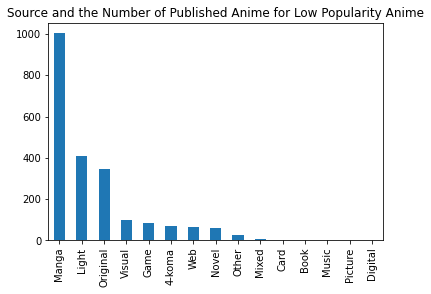

In [2625]:
plt.title('Source and the Number of Published Anime for Low Popularity Anime')
source_appearances = df_lowpop['Source Type'].value_counts()
source_appearances.plot(kind = 'bar')

In [2725]:
#plt.title('Genres and the Number of Published Anime for High Popularity Anime')
#genre_appearances = df_highpop.Genres.value_counts()
#genre_appearances[genre_appearances > 7.5].plot(kind = 'bar')

## Models ##

First of all we will split the data into a training set and a final test set.

In [2629]:
from sklearn.model_selection import train_test_split

x = df.drop(['Title', 'Episode Duration', 'Genres', 'Themes', 'Popularity'], axis=1)
x = x.drop(['Studios', 'Source Type', 'Type', 'Rating', 'Demographic', 'MAL Id'], axis=1)
y = df[['Popularity']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

### Dummies ###

In [2630]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import accuracy_score

In [2631]:
dummy_regr = DummyRegressor(strategy="mean")
score = np.median(cross_val_score(dummy_regr, x_train, y_train, cv=30))
score

-0.002678812411892162

### K Nearest Neighbor ###

Import 'KNeighborsClassifier'.

In [2632]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

Lets find the most suitable K (nearest neighbors).

In [2633]:
k_range = range(1, 101)

scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    score = np.median(cross_val_score(knn, x_train, y_train, cv=30))
    scores.append(score)

index = scores.index(np.max(scores))
print(np.max(scores), index)

0.36356413040553875 77


### Linear Regression ###

Import 'LinearRegression'.

In [2634]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [2635]:
regressor = LinearRegression()
score = np.median(cross_val_score(regressor, x_train, y_train, cv=30))
#mean_absolute_error(y_true, y_pred)
print(score)

0.6166119282845282


### Decision Tree Regressor ###

Import 'DecisionTreeRegressor'.

In [2636]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

Lets find the most suitable Depth.

In [2637]:
scores = []

for depth in range(1,101):
    regressor = DecisionTreeRegressor(max_depth=depth)
    score = np.median(cross_val_score(regressor, x_train, y_train, cv=30))
    scores.append(score)

index = scores.index(np.max(scores))
print(np.max(scores), index)

0.585094895867152 6


### Random Forest Regressor ###

Import 'RandomForestRegressor'.

In [2638]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [2639]:
regressor = RandomForestRegressor()
score = np.median(cross_val_score(regressor, x_train, y_train, cv=30))
print(score)

0.7076406234843785
